# Dyna-Q vs. Dyna-Q+

In [690]:
%reload_ext autoreload
%autoreload 2

In [691]:
import sys
sys.path.append('../../modules')

import json

import random
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm

from env.gridworld import GridWorldWithWallsAndTraps
from policy import EpsilonGreedyPolicy

from algo.planning import QLearningBase

from algo.planning_cbs.cb_handler import CallbackHandler
from algo.planning_cbs.dynaq import DynaQ
from algo.planning_cbs.dynaqplus import DynaQPlus
from algo.planning_cbs.episode_length_tracker import EpisodeLengthTracker
from algo.planning_cbs.value_function_tracker import ValueFunctionTracker

In [692]:
img_save_dir = "/Users/yangzhihan/Desktop/projects/deeprl_notes_site/images/2020-08-11-dynaq"

In [693]:
grid_type_array_1 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
])

grid_type_array_2 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
])

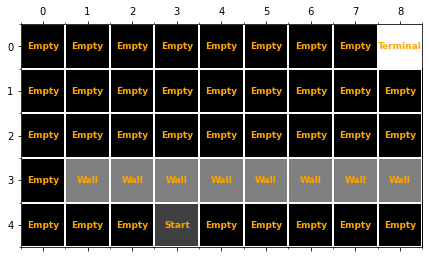

In [694]:
plt.matshow(grid_type_array_1, cmap='gray')

for (i, j), z in np.ndenumerate(grid_type_array_1):
    
    if z == 0:
        text = 'Empty'
    elif z == 1:
        text = 'Start'
    elif z == 2:
        text = 'Wall'
    elif z == 4:
        text = 'Terminal'
    
    plt.text(
        j, i, text,
        ha='center', va='center', color='orange', fontsize=9, weight='bold',
    )

ax = plt.gca()
ax.set_xticks(np.arange(-.5, 9, 1), minor=True);
ax.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)

plt.savefig(f'{img_save_path}/shortcut_maze_1.png', dpi=300, bbox_inches = 'tight', pad_inches = 0.1)

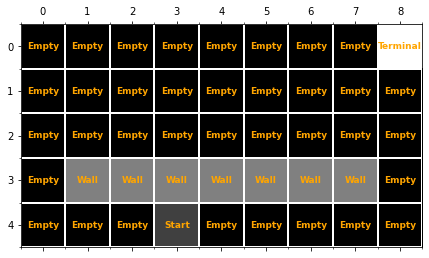

In [695]:
plt.matshow(grid_type_array_2, cmap='gray')

for (i, j), z in np.ndenumerate(grid_type_array_2):
    
    if z == 0:
        text = 'Empty'
    elif z == 1:
        text = 'Start'
    elif z == 2:
        text = 'Wall'
    elif z == 4:
        text = 'Terminal'
    
    plt.text(
        j, i, text,
        ha='center', va='center', color='orange', fontsize=9, weight='bold',
    )

ax = plt.gca()
ax.set_xticks(np.arange(-.5, 9, 1), minor=True);
ax.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)

plt.savefig(f'{img_save_path}/shortcut_maze_2.png', dpi=300, bbox_inches = 'tight', pad_inches = 0.1)

In [696]:
reward_array = np.zeros_like(grid_type_array_1)
reward_array[0, -1] = 1

In [697]:
reward_array

array([[0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [698]:
int_to_action_dict = {
    0 : 'up',
    1 : 'right',
    2 : 'down',
    3 : 'left'
}

## Run the algorithm

In [699]:
env_1 = GridWorldWithWallsAndTraps(grid_type_array_1, reward_array, int_to_action_dict)
env_2 = GridWorldWithWallsAndTraps(grid_type_array_2, reward_array, int_to_action_dict)

In [700]:
planning_ratio = 10

In [703]:
cb_handler = CallbackHandler(cbs=[
    DynaQ(planning_ratio), 
    EpisodeLengthTracker(),
])

random.seed(42)
np.random.seed(42)

algo1 = QLearningBase(
    env=env_1, 
    policy=EpsilonGreedyPolicy(q=np.zeros(env_1.action_space_shape), epsilon=0.1), 
    alpha=1,  # seems like a very large learning rate to me; necessary to replicate the book's result
    gamma=0.95, 
    cb_handler=cb_handler
)

algo1.run(max_iterations=100)

algo1.env = env_2

algo1.run(max_iterations=200)

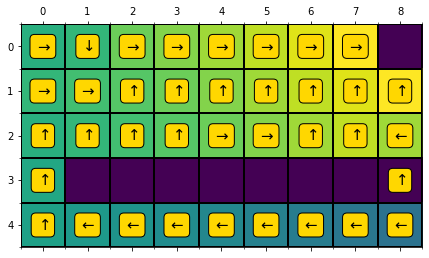

In [704]:
algo1.plot_value_function_and_policy(f'{img_save_dir}/dynaq_shortcut_maze_2_policy.png')

## Dyna-Q+ learned policy

In [705]:
planning_ratio = 10
k = 1e-3

In [706]:
random.seed(42)
np.random.seed(42)

algo2 = QLearningBase(
    env=env_1, 
    policy=EpsilonGreedyPolicy(q=np.zeros(env_1.action_space_shape), epsilon=0.1), 
    alpha=1,  # seems like a very large learning rate to me; necessary to replicate the book's result
    gamma=0.95, 
    cb_handler=CallbackHandler(
        cbs=[
            DynaQPlus(planning_ratio, k, env_1), 
            EpisodeLengthTracker(),
        ]
    )
)

algo2.run(100)

algo2.env = env_2

algo2.run(200)

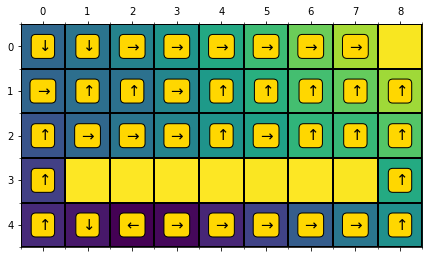

In [707]:
algo2.plot_value_function_and_policy(f'{img_save_dir}/dynaqplus_shortcut_maze_2_policy.png')

# Performance comparison

In [708]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

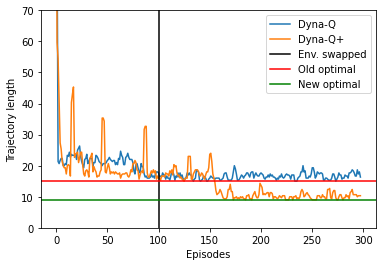

In [709]:
plt.plot(smooth(algo1.cb_handler.cbs[1].values, 3), label='Dyna-Q')
plt.plot(smooth(algo2.cb_handler.cbs[1].values, 3), label='Dyna-Q+')
plt.ylim(0, 70)
plt.axvline(x=100, color='black', label='Env. swapped')
plt.axhline(y=15, color='red', label='Old optimal')
plt.axhline(y=9, color='green', label='New optimal')
plt.legend()
plt.xlabel('Episodes'); plt.ylabel('Trajectory length');
plt.savefig(f'{img_save_path}/dynaq_vs_dynaqplus_trajectory_length.png', dpi=300, bbox_inches='tight', pad_inches=0)